In [41]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

from medmnist import BreastMNIST
from medmnist import INFO

import pennylane as qml

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Using: {torch.cuda.get_device_name(0)}")
    print(f"CUDA: {torch.version.cuda}")
else:
    print("CUDA is not available. Using CPU.")

Using: NVIDIA GeForce RTX 4070 Ti SUPER
CUDA: 12.4


In [43]:
info = INFO['breastmnist']
data_flag = 'breastmnist'
DataClass = BreastMNIST

task = info['task']  
n_channels = info['n_channels']
n_classes = len(info['label'])

print(f"Number of classes:", n_classes)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
    lambda x: x.unsqueeze(0) 
])

Number of classes: 2


## **Dataset Configuration for 28x28 and 64x64 Images**

In the following code, the dataset is configured to use images of size 28x28, which is the default setting for the BreastMNIST dataset (and other similar datasets like MedMNIST). 

In [44]:
data_train28 = DataClass(split='train', transform=transform, download=True)
data_test28 = DataClass(split='test', transform=transform, download=True)
data_eval28 = DataClass(split='val', transform=transform, download=True)

Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist.npz


For the case you want to use images of size 64x64, the code can be adjusted to load the dataset with this specific size by setting the `size` parameter to 64.

In [45]:
data_train64 = DataClass(split='train', transform=transform, download=True, size=64)
data_test64 = DataClass(split='test', transform=transform, download=True, size=64)
data_eval64 = DataClass(split='val', transform=transform, download=True, size=64)

Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist_64.npz
Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist_64.npz
Using downloaded and verified file: /home/eflammere/.medmnist/breastmnist_64.npz


## **Dataloader: Train, Test and Validation**

The following code snippet demonstrates how to load the training, test, and validation splits of the dataset:


In [46]:
batch_size = 64  
dataloader_train = data.DataLoader(dataset=data_train28, batch_size=batch_size, shuffle=True)
dataloader_test = data.DataLoader(dataset=data_test28, batch_size=batch_size, shuffle=False)
dataloader_eval = data.DataLoader(dataset=data_eval28, batch_size=batch_size, shuffle=False)

print(f"\nNumber of images in training dataset: {len(data_train28)}")
print(f"Number of images in test dataset: {len(data_test28)}")
print(f"Number of images in validation dataset: {len(data_eval28)}")



Number of images in training dataset: 546
Number of images in test dataset: 156
Number of images in validation dataset: 78


# **Quanvolution**

Designed to process an image by applying a quantum circuit to extract features from it. It works similarly to a convolutional layer in a neural network, but instead of using traditional mathematical filters, it leverages a quantum circuit to process small patches of the image and generate new features.

In [47]:
def quanvolution(image, circuit, patch_size, n_qubits):
    """
    Perform quanvolution on the input image using the given quantum circuit.
    
    Args:
    - image (ndarray): The input image (2D or 3D with channels).
    - circuit (function): The quantum circuit function to extract features.
    - patch_size (int): The size of the patches to divide the image into.
    - n_qubits (int): Number of qubits in the quantum circuit.
    
    Returns:
    - out (ndarray): The output tensor after quanvolution.
    """
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)
    
    height_patches = image.shape[0] // patch_size
    width_patches = image.shape[1] // patch_size
    
    out = np.zeros((height_patches, width_patches, n_qubits))
    
    for j in range(height_patches):
        for k in range(width_patches):
            patch = []
            for i in range(patch_size):
                for l in range(patch_size):
                    if (j * patch_size + i < image.shape[0]) and (k * patch_size + l < image.shape[1]):
                        patch.append(image[j * patch_size + i, k * patch_size + l, 0])
                    else:
                        patch.append(0)
            
            q_results = circuit(patch)
            
            for c in range(n_qubits):
                out[j, k, c] = q_results[c]
    
    return out

def quanvolution_batch(images, circuit, patch_size, n_qubits):
    """
    Applies quanvolution to a batch of images.

    Args:
    - images: Input tensor (batch_size, H, W, C).
    - circuit: Quantum circuit used for the quanvolution.
    - patch_size: Size of the patches used in the quanvolution.
    - n_qubits: Number of qubits in the quantum circuit.

    Returns:
    - Processed tensor after quanvolution.
    """
    batch_size = images.shape[0]
    processed = [
        quanvolution(images[i].detach().cpu().numpy(), circuit, patch_size, n_qubits)
        for i in range(batch_size)
    ]

    processed = np.array(processed)
    return torch.tensor(processed, dtype=torch.float32).to(images.device)

In [48]:
# dev = qml.device("default.qubit", wires=4)
# # Parâmetros aleatórios para o circuito
# n_layers = 2
# rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

# @qml.qnode(dev, interface="torch")
# def circuit(phi):
#     # Codificação de 4 valores de entrada clássicos
#     for j in range(4):
#         qml.RY(np.pi * phi[j], wires=j)

#     # Camadas quânticas aleatórias
#     qml.templates.layers.RandomLayers(rand_params, wires=list(range(4)))

#     # Medidas produzindo 4 valores clássicos de saída
#     return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [49]:
import pennylane as qml
import numpy as np

# Configurar dispositivo
n_qubits = 4
n_layers = 1

# Parâmetros aleatórios
np.random.seed(42)
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, n_qubits))

# Definir a função que retorna o dispositivo
def get_device(n_qubits):
    return qml.device("default.qubit", wires=n_qubits)

# Definir o circuito com camadas customizadas e RandomLayers
def define_circuit(rand_params):
    """
    Define a parametrized quantum circuit with custom layers and RandomLayers.

    Args:
    - rand_params: Parameters for the circuit layers.

    Returns:
    - A quantum circuit function (qml.QNode).
    """
    dev = get_device(n_qubits)

    @qml.qnode(dev, interface='torch')
    def circuit(phi):
        # Entrada inicial: aplica rotações baseadas em phi (dados de entrada)
        for j in range(n_qubits):
            qml.RY(np.pi * phi[j], wires=j)

        qml.templates.layers.RandomLayers(rand_params, list(range(n_qubits)))

        # Medição: expectativa do operador Pauli-Z em cada qubit
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

    return circuit

rand_circuit = define_circuit(rand_params)

phi = np.random.uniform(size=n_qubits)

result = rand_circuit(phi)

expanded_circuit = rand_circuit.qtape.expand()
print(expanded_circuit.draw())

0: ──RY────────────────┤  <Z>
1: ──RY──RY─╭●─────────┤  <Z>
2: ──RY──RX─│───RZ──RX─┤  <Z>
3: ──RY─────╰X─────────┤  <Z>


## **Quanvolution4x1**

*4 qubits, 2 layers, 1 quanvolution*

In [50]:
class Quanvolution4x1Model(nn.Module):
    def __init__(self, rand_params, output_size = (14, 14), patch_size = 2, n_qubits = 4, num_classes = 2):
        """
        Defines the CNN with quanvolution.

        Args:
        - rand_params: Parameters of the quantum circuit.
        - output_size: Output size after quanvolution.
        - n_qubits: Number of qubits in the quantum circuit.
        - num_classes: Number of classes for classification.
        """
        super(Quanvolution4x1Model, self).__init__()
        self.output_size = output_size
        self.patch_size = patch_size
        self.n_qubits = n_qubits
        self.num_classes = num_classes
        
        self.circuit = define_circuit(rand_params)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(output_size[0] * output_size[1] * n_qubits, num_classes)

    def forward(self, x):
        """
        Passes the data through the network.

        Args:
        - x: Input tensor (batch_size, C, H, W).
        
        Returns:
        - Logarithmic probabilities of the classes (batch_size, num_classes).
        """
        x = x.permute(0, 2, 3, 1)
        x = quanvolution_batch(x, self.circuit, self.patch_size, self.n_qubits)
        x = torch.relu(x)
        x = self.flatten(x) 
        x = self.fc(x)  
        return F.log_softmax(x, dim=1)

## **Quanvolution4x2**

*4 qubits, 1 quantum layer per quanvolution, 2 quanvolution*

In [51]:
class Quanvolution4x2Model(nn.Module):
    def __init__(self, rand_params, output_size = (14, 14), patch_size = 2, n_qubits = 4, num_classes = 2):
        """
        Defines the CNN with multiple quanvolution layers.

        Args:
        - rand_params: Parameters of the quantum circuit.
        - output_size: Output size after the first quanvolution.
        - n_qubits: Number of qubits in the quantum circuit.
        - num_classes: Number of classes for classification.
        """
        super(Quanvolution4x2Model, self).__init__()
        self.output_size = output_size
        self.patch_size = patch_size
        self.n_qubits = n_qubits
        self.num_classes = num_classes

        self.circuit = define_circuit(rand_params)

        self.flatten = nn.Flatten()
        self.fc_intermediate = None 
        self.fc = nn.Linear(128, num_classes)

    def initialize_fc_intermediate(self, x):
        """
        Dynamically initializes the intermediate fully connected layer based on the input size.

        Args:
        - x: Input tensor after quanvolution.
        """
        if self.fc_intermediate is None:
            flattened_size = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc_intermediate = nn.Linear(flattened_size, 128).to(x.device)
        
    def forward(self, x):
        """
        Passes the data through the network.

        Args:
        - x: Input tensor (batch_size, C, H, W).
        
        Returns:
        - Logarithmic probabilities of the classes (batch_size, num_classes).
        """
        x = x.permute(0, 2, 3, 1)
        x = quanvolution_batch(x, self.circuit, self.patch_size, self.n_qubits)
        #print(x.shape)
        x = (x - x.mean()) / (x.std() + 1e-8)
        x = torch.relu(x)
        x = quanvolution_batch(x, self.circuit, self.patch_size, self.n_qubits)
        #print(x.shape)
        x = torch.relu(x)

        self.initialize_fc_intermediate(x)

        x = self.flatten(x)
        x = self.fc_intermediate(x)
        x = torch.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

## **Quanvolution4x1x1**

*4 qubits, 2 quantum layers per quanvolution, 1 convolution, 1 quanvolution*

In [52]:
class Quanvolution4x1x1Model(nn.Module):
    def __init__(self, rand_params, output_size=(14, 14), patch_size=2, n_qubits=4, num_classes=2, conv_out_channels=16, kernel_size=3):
        """
        Defines the CNN with multiple quanvolution layers and a classical convolution layer.

        Args:
        - rand_params: Parameters of the quantum circuit.
        - output_size: Output size after the first quanvolution.
        - patch_size: Size of the patches for quanvolution.
        - n_qubits: Number of qubits in the quantum circuit.
        - num_classes: Number of classes for classification.
        - conv_out_channels: Number of output channels for the classical convolution.
        - kernel_size: Kernel size for the classical convolution.
        """
        super(Quanvolution4x1x1Model, self).__init__()
        self.output_size = output_size
        self.patch_size = patch_size
        self.n_qubits = n_qubits
        self.num_classes = num_classes

        self.conv = nn.Conv2d(in_channels=1, out_channels=conv_out_channels, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()

        self.circuit = define_circuit(rand_params)

        self.flatten = nn.Flatten()
        self.fc_intermediate = None 
        self.fc = nn.Linear(128, num_classes)

    def initialize_fc_intermediate(self, x):
        """
        Dynamically initializes the intermediate fully connected layer based on the input size.

        Args:
        - x: Input tensor after quanvolution.
        """
        if self.fc_intermediate is None:
            flattened_size = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc_intermediate = nn.Linear(flattened_size, 128).to(x.device)


    def forward(self, x):
        """
        Passes the data through the network.

        Args:
        - x: Input tensor (batch_size, C, H, W).
        
        Returns:
        - Logarithmic probabilities of the classes (batch_size, num_classes).
        """
        x = self.conv(x)
        x = self.relu(x)

        x = x.permute(0, 2, 3, 1)
        x = quanvolution_batch(x, self.circuit, self.patch_size, self.n_qubits)
        x = torch.relu(x)

        self.initialize_fc_intermediate(x)

        x = self.flatten(x)
        x = self.fc_intermediate(x)
        x = torch.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

## **Quanvolution4x1x2**

*4 qubits, 1 quantum layer per quanvolution, 1 convolution, 2 quanvolution*

In [53]:
class Quanvolution4x1x2Model(nn.Module):
    def __init__(self, rand_params, output_size=(14, 14), patch_size=2, n_qubits=4, num_classes=2, conv_out_channels=16, kernel_size=3):
        """
        Defines the CNN with multiple quanvolution layers and a classical convolution layer.

        Args:
        - rand_params: Parameters of the quantum circuit.
        - output_size: Output size after the first quanvolution.
        - patch_size: Size of the patches for quanvolution.
        - n_qubits: Number of qubits in the quantum circuit.
        - num_classes: Number of classes for classification.
        - conv_out_channels: Number of output channels for the classical convolution.
        - kernel_size: Kernel size for the classical convolution.
        """
        super(Quanvolution4x1x2Model, self).__init__()
        self.output_size = output_size
        self.patch_size = patch_size
        self.n_qubits = n_qubits
        self.num_classes = num_classes

        self.conv = nn.Conv2d(in_channels=1, out_channels=conv_out_channels, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()

        self.circuit = define_circuit(rand_params)

        self.flatten = nn.Flatten()
        self.fc_intermediate = None 
        self.fc = nn.Linear(128, num_classes)

    def initialize_fc_intermediate(self, x):
        """
        Dynamically initializes the intermediate fully connected layer based on the input size.

        Args:
        - x: Input tensor after quanvolution.
        """
        if self.fc_intermediate is None:
            flattened_size = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc_intermediate = nn.Linear(flattened_size, 128).to(x.device)


    def forward(self, x):
        """
        Passes the data through the network.

        Args:
        - x: Input tensor (batch_size, C, H, W).
        
        Returns:
        - Logarithmic probabilities of the classes (batch_size, num_classes).
        """
        x = self.conv(x)
        x = self.relu(x)

        x = x.permute(0, 2, 3, 1)
        x = quanvolution_batch(x, self.circuit, self.patch_size, self.n_qubits)
        x = torch.relu(x)

        x = quanvolution_batch(x, self.circuit, self.patch_size, self.n_qubits)
        x = torch.relu(x)

        self.initialize_fc_intermediate(x)

        x = self.flatten(x)
        x = self.fc_intermediate(x)
        x = torch.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


In [54]:
class Quanvolution4x2x2Model(nn.Module):
    def __init__(self, rand_params, output_size=(14, 14), patch_size=2, n_qubits=4, num_classes=2, conv_out_channels=16, kernel_size=3):
        """
        Defines the CNN with multiple quanvolution layers and a classical convolution layer.

        Args:
        - rand_params: Parameters of the quantum circuit.
        - output_size: Output size after the first quanvolution.
        - patch_size: Size of the patches for quanvolution.
        - n_qubits: Number of qubits in the quantum circuit.
        - num_classes: Number of classes for classification.
        - conv_out_channels: Number of output channels for the classical convolution.
        - kernel_size: Kernel size for the classical convolution.
        """
        super(Quanvolution4x2x2Model, self).__init__()
        self.output_size = output_size
        self.patch_size = patch_size
        self.n_qubits = n_qubits
        self.num_classes = num_classes

        self.conv = nn.Conv2d(in_channels=1, out_channels=conv_out_channels, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()

        self.circuit = define_circuit(rand_params)

        self.flatten = nn.Flatten()
        self.fc_intermediate = None 
        self.fc = nn.Linear(128, num_classes)

    def initialize_fc_intermediate(self, x):
        """
        Dynamically initializes the intermediate fully connected layer based on the input size.

        Args:
        - x: Input tensor after quanvolution.
        """
        if self.fc_intermediate is None:
            flattened_size = x.shape[1] * x.shape[2] * x.shape[3]
            self.fc_intermediate = nn.Linear(flattened_size, 128).to(x.device)


    def forward(self, x):
        """
        Passes the data through the network.

        Args:
        - x: Input tensor (batch_size, C, H, W).
        
        Returns:
        - Logarithmic probabilities of the classes (batch_size, num_classes).
        """
        x = self.conv(x)
        x = self.relu(x)

        x = x.permute(0, 2, 3, 1)
        x = quanvolution_batch(x, self.circuit, self.patch_size, self.n_qubits)
        x = torch.relu(x)

        x = self.conv(x)
        x = self.relu(x)

        x = x.permute(0, 2, 3, 1)
        x = quanvolution_batch(x, self.circuit, self.patch_size, self.n_qubits)
        x = torch.relu(x)

        self.initialize_fc_intermediate(x)

        x = self.flatten(x)
        x = self.fc_intermediate(x)
        x = torch.relu(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [55]:
model = Quanvolution4x2Model(rand_params).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss().to(device)
epochs = 30

In [56]:
for epoch in range(epochs): 
    model.train()
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    for batch_idx, (images, labels) in enumerate(dataloader_train, 1):
        images, labels = images.squeeze(1).to(device), labels.squeeze().to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
               print(f"{name}: Gradiente médio {param.grad.abs().mean()}")

        optimizer.step()

        total_loss += loss.item()
        all_labels.append(labels)
        all_predictions.append(output)

        print(f"Epoch {epoch+1} Batch {batch_idx}/{len(dataloader_train)} Loss: {loss.item():.4f}")

    print(f"Epoch {epoch+1} Training Loss: {total_loss / len(dataloader_train):.4f}")


fc.weight: Gradiente médio 0.022824741899967194
fc.bias: Gradiente médio 0.19533714652061462
fc_intermediate.weight: Gradiente médio 0.00191694893874228
fc_intermediate.bias: Gradiente médio 0.0071063111536204815
Epoch 1 Batch 1/9 Loss: 0.6825
fc.weight: Gradiente médio 0.02044595405459404
fc.bias: Gradiente médio 0.1570284068584442
fc_intermediate.weight: Gradiente médio 0.0035692343953996897
fc_intermediate.bias: Gradiente médio 0.013260073959827423
Epoch 1 Batch 2/9 Loss: 0.6079
fc.weight: Gradiente médio 0.006601417902857065
fc.bias: Gradiente médio 0.03316666558384895
fc_intermediate.weight: Gradiente médio 0.003910827916115522
fc_intermediate.bias: Gradiente médio 0.014175163581967354
Epoch 1 Batch 3/9 Loss: 0.6180
fc.weight: Gradiente médio 0.007959913462400436
fc.bias: Gradiente médio 0.0494462251663208
fc_intermediate.weight: Gradiente médio 0.0039052870124578476
fc_intermediate.bias: Gradiente médio 0.012663496658205986
Epoch 1 Batch 4/9 Loss: 0.6325
fc.weight: Gradiente médi

In [57]:
val_loss = 0.0
val_labels = []
val_predictions = []

model.eval() 

with torch.no_grad():
    for images, labels in dataloader_eval:
        images, labels = images.squeeze(1).to(device), labels.squeeze().to(device)
        output = model(images)
        loss = criterion(output, labels)

        val_loss += loss.item()
        val_labels.append(labels)
        val_predictions.append(output)

val_labels = torch.cat(val_labels)
val_predictions = torch.cat(val_predictions)
val_accuracy = accuracy_score(val_labels.cpu().numpy(), val_predictions.argmax(dim=1).cpu().numpy())
val_precision = precision_score(val_labels.cpu().numpy(), val_predictions.argmax(dim=1).cpu().numpy(), average="weighted", zero_division=0)
val_recall = recall_score(val_labels.cpu().numpy(), val_predictions.argmax(dim=1).cpu().numpy(), average="weighted", zero_division=0)
val_f1 = f1_score(val_labels.cpu().numpy(), val_predictions.argmax(dim=1).cpu().numpy(), average="weighted", zero_division=0)

print(f"Validation Loss: {val_loss / len(dataloader_eval):.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

Validation Loss: 0.5518
Validation Accuracy: 0.7436
Validation Precision: 0.7121
Validation Recall: 0.7436
Validation F1 Score: 0.6805


In [58]:
test_loss = 0.0
test_labels = []
test_predictions = []

model.eval()

with torch.no_grad():
    for images, labels in dataloader_test:
        images, labels = images.squeeze(1).to(device), labels.squeeze().to(device)
        output = model(images)
        loss = criterion(output, labels)

        test_loss += loss.item()
        test_labels.append(labels)
        test_predictions.append(output)

test_labels = torch.cat(test_labels)
test_predictions = torch.cat(test_predictions)
test_accuracy = accuracy_score(test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy())
test_precision = precision_score(test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), average="weighted", zero_division=0)
test_recall = recall_score(test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), average="weighted", zero_division=0)
test_f1 = f1_score(test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), average="weighted", zero_division=0)

print("\nFinal Test Evaluation:")
print(f"Test Loss: {test_loss / len(dataloader_test):.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")



Final Test Evaluation:
Test Loss: 0.5188
Test Accuracy: 0.7244
Test Precision: 0.6667
Test Recall: 0.7244
Test F1 Score: 0.6602


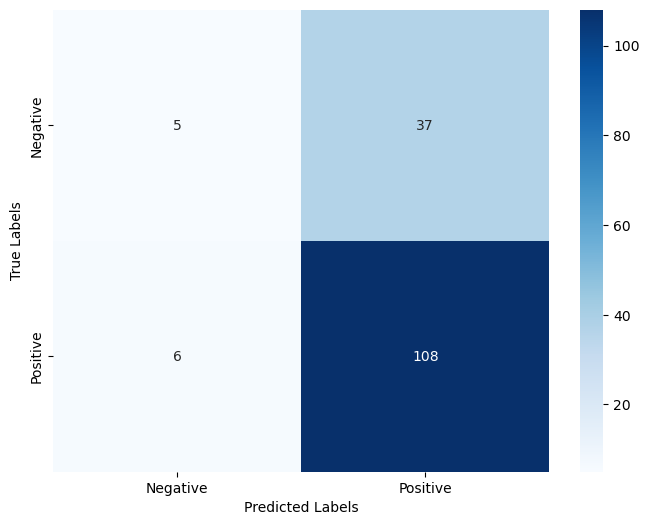

In [59]:
cm = confusion_matrix(test_labels.cpu().numpy(), test_predictions.argmax(dim=1).cpu().numpy(), labels=[0, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()